In [1]:
!pip install torch torchvision
!pip install numpy pandas matplotlib pillow scikit-learn img2vec-pytorch

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from PIL import Image
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from torchvision import transforms
import pandas as pd
from PIL import Image
import os
from img2vec_pytorch import Img2Vec
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


In [3]:
torch.cuda.is_available()

True

In [4]:
folder_path = '../scratch/ml2_data/20251214_140311'
images = []
for filename in os.listdir(folder_path):
    if filename.endswith('.jpg'):
        img_path = os.path.join(folder_path, filename)
        img = Image.open(img_path)
        width, height = img.size
        cropped_img = img.crop((100, 100, width, height))
        images.append(cropped_img)

In [5]:
encoder = Img2Vec(model='alexnet',cuda=True)
vectors = encoder.get_vec(images)

In [6]:
from sklearn.model_selection import train_test_split

idexes = np.arange(len(images))
train_idxs, test_idxs = train_test_split(
    idexes,
    test_size=0.2, 
    random_state=42 
)

train_images = np.array([images[x] for x in train_idxs])
train_vectors =  np.array([vectors[x] for x in train_idxs])

test_images =  np.array([images[x] for x in test_idxs])
test_vectors =  np.array([vectors[x] for x in test_idxs])

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [8]:
from torch.utils.data import DataLoader, TensorDataset
train_tensor = torch.tensor(train_vectors, dtype=torch.float32)
test_tensor  = torch.tensor(test_vectors, dtype=torch.float32)

dataset = TensorDataset(train_tensor)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

In [128]:
class VAE(nn.Module):
    def __init__(self, latent_dim=16):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Linear(4096, 1024),
            nn.ReLU(),
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU()
        )


        self.fc_mu = nn.Linear(64, latent_dim)
        self.fc_logvar = nn.Linear(64, latent_dim)

  
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 256),
            nn.ReLU(),
            nn.Linear(256, 1024),
            nn.ReLU(),
            nn.Linear(1024, 4096)
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)

        z = self.reparameterize(mu, logvar)
        reconstructed = self.decoder(z)

        return reconstructed, mu, logvar

    def get_latent(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        z = self.reparameterize(mu, logvar)
        return z

In [129]:
def vae_loss(reconstructed, x, mu, logvar):
    beta = 1
    recon_loss = F.mse_loss(reconstructed, x, reduction='sum')

    kl_loss = beta * -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return recon_loss +  kl_loss,recon_loss,kl_loss

In [130]:
model = VAE().to(device)
criterion = vae_loss
optimizer = torch.optim.Adam(model.parameters())

In [131]:
num_epochs = 60
train_losses = []
recon_losses = []
kl_losses = []
test_losses = []

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0.0
    total_recon_loss = 0.0
    total_kl_loss = 0.0
    for (x,) in loader:
        x = x.to(device)
        optimizer.zero_grad()
        recon, mu, logvar = model(x)
        loss, recon_loss, kl_loss = criterion(recon, x, mu, logvar)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
        total_recon_loss += recon_loss.item()
        total_kl_loss += kl_loss.item()
    
    avg_train_loss = total_train_loss / len(loader)
    avg_recon_loss = total_recon_loss / len(loader)
    avg_kl_loss = total_kl_loss / len(loader)
    
    train_losses.append(avg_train_loss)
    recon_losses.append(avg_recon_loss)
    kl_losses.append(avg_kl_loss)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.6f}")

Epoch [1/60], Train Loss: 37586.475060
Epoch [2/60], Train Loss: 11804.669296
Epoch [3/60], Train Loss: 11295.364959
Epoch [4/60], Train Loss: 11154.300618
Epoch [5/60], Train Loss: 11066.281500
Epoch [6/60], Train Loss: 11024.764623
Epoch [7/60], Train Loss: 10898.771409
Epoch [8/60], Train Loss: 10720.903596
Epoch [9/60], Train Loss: 9738.992275
Epoch [10/60], Train Loss: 8042.529923
Epoch [11/60], Train Loss: 7174.266890
Epoch [12/60], Train Loss: 6574.402381
Epoch [13/60], Train Loss: 5748.894757
Epoch [14/60], Train Loss: 5389.493690
Epoch [15/60], Train Loss: 5312.814810
Epoch [16/60], Train Loss: 5096.331299
Epoch [17/60], Train Loss: 4889.074394
Epoch [18/60], Train Loss: 4749.489045
Epoch [19/60], Train Loss: 4716.947817
Epoch [20/60], Train Loss: 4555.785494
Epoch [21/60], Train Loss: 4418.345434
Epoch [22/60], Train Loss: 4206.992757
Epoch [23/60], Train Loss: 4073.486190
Epoch [24/60], Train Loss: 3933.912128
Epoch [25/60], Train Loss: 3793.404147
Epoch [26/60], Train Loss:

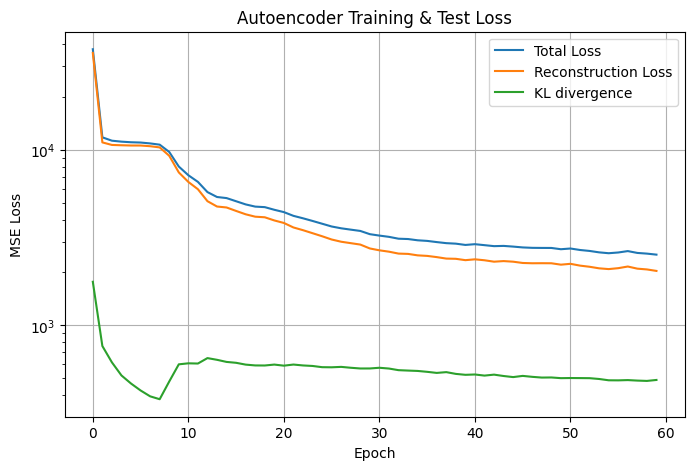

In [132]:
plt.figure(figsize=(8,5))
plt.plot(train_losses, label='Total Loss')
plt.plot(recon_losses, label='Reconstruction Loss')
plt.plot(kl_losses, label='KL divergence')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Autoencoder Training & Test Loss')
plt.legend()
plt.yscale('log')
plt.grid(True)
plt.show()

# Latent space analysis

In [133]:
with torch.no_grad():
    train_latent = model.get_latent(train_tensor.to(device))

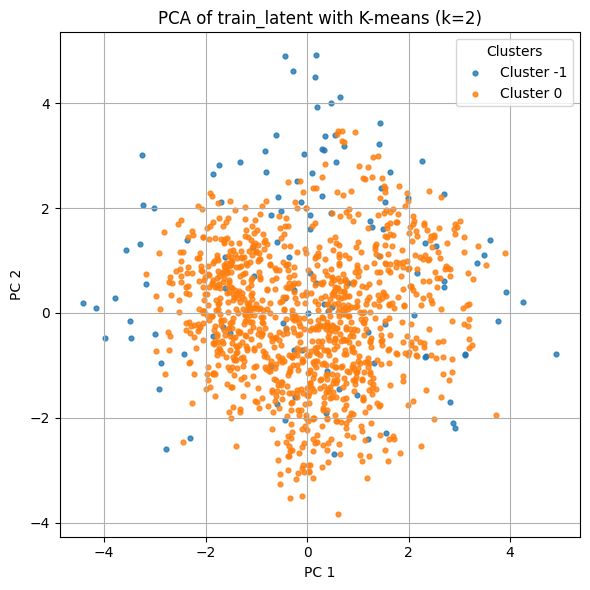

In [155]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
X = train_latent.detach().cpu().numpy()


# kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
# clusters = kmeans.fit_predict(X)

dbscan = DBSCAN(eps=3.3, min_samples=45)
clusters = dbscan.fit_predict(X)


pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(6, 6))


for cluster_id in np.unique(clusters):
    idx = clusters == cluster_id
    plt.scatter(
        X_pca[idx, 0],
        X_pca[idx, 1],
        s=12,
        alpha=0.8,
        label=f"Cluster {cluster_id}"
    )

plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.title("PCA of train_latent with K-means (k=2)")
plt.legend(title="Clusters")
plt.grid(True)
plt.tight_layout()
plt.show()

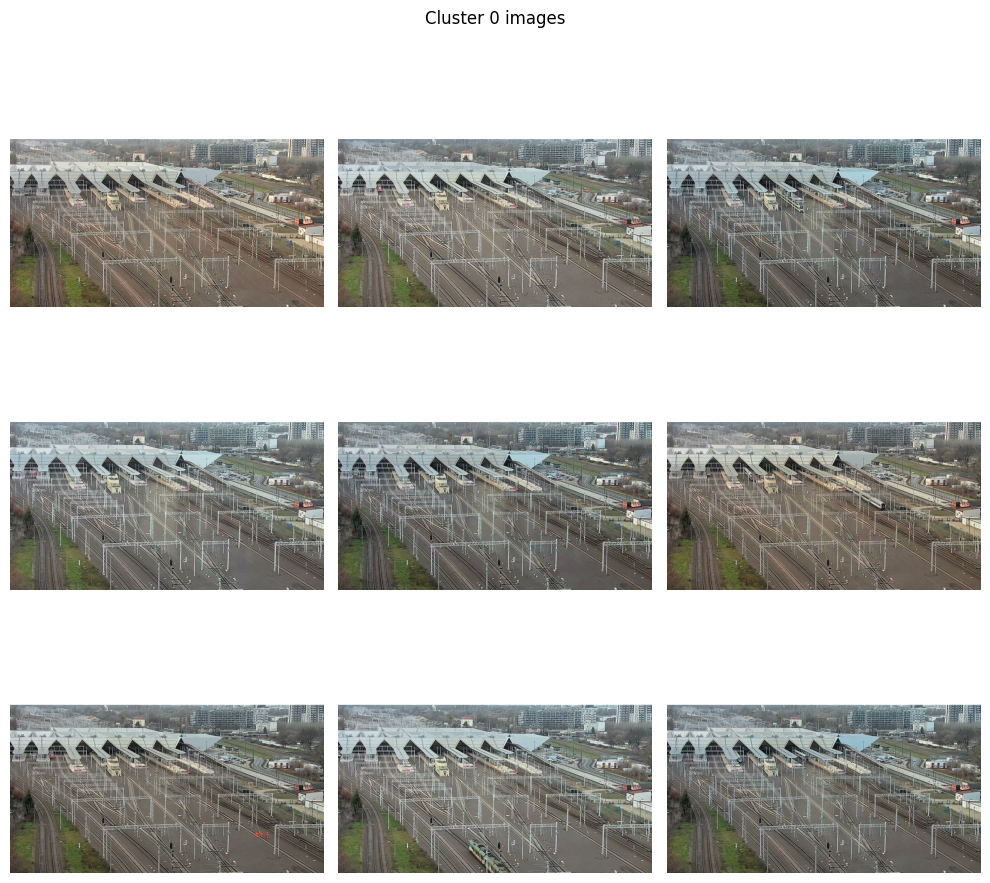

In [156]:
cluster_zero_images = []
for i in range(len(train_images)):
    if clusters[i]==0:
        cluster_zero_images.append(train_images[i])


plt.figure(figsize=(10, 10))

for i in range(9): 
    plt.subplot(3, 3, i+1)
    plt.imshow(cluster_zero_images[i])
    
    plt.axis("off")

plt.suptitle('Cluster 0 images')
plt.tight_layout()
plt.show()

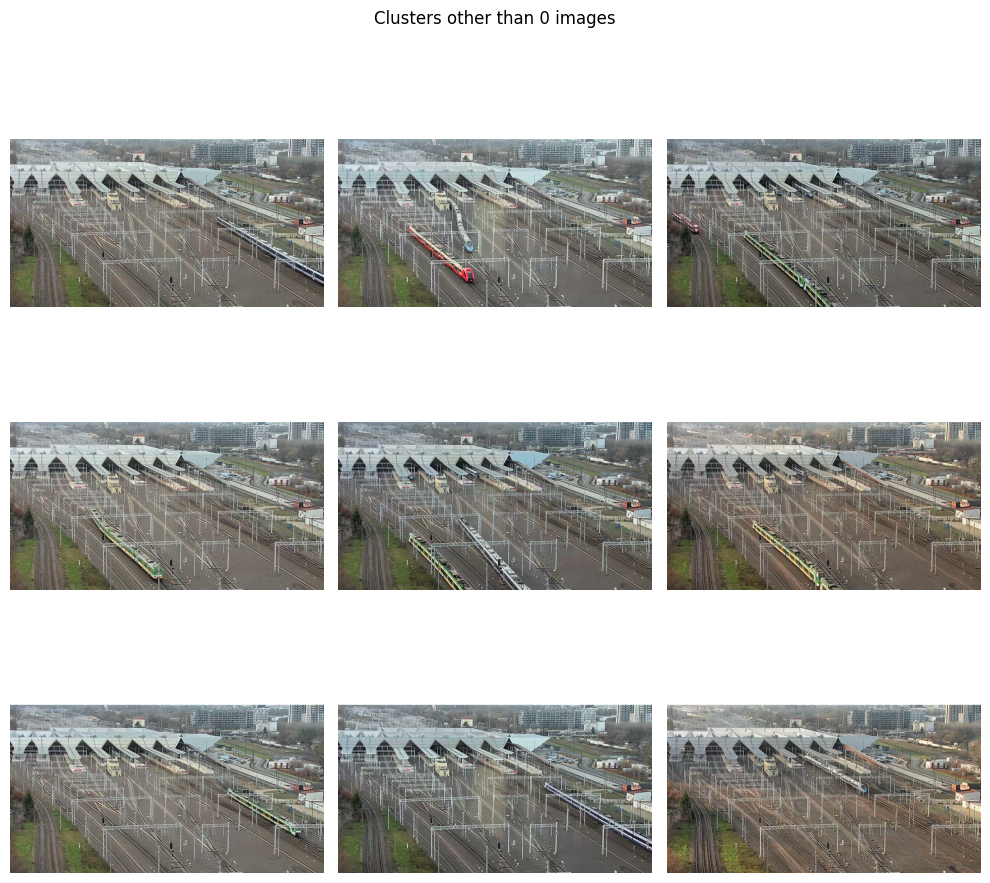

In [157]:
cluster_nonzero_images = []
for i in range(len(train_images)):
    if clusters[i]==-1:
        cluster_nonzero_images.append(train_images[i])


plt.figure(figsize=(10, 10))

for i in range(9): 
    plt.subplot(3, 3, i+1)
    plt.imshow(cluster_nonzero_images[i])
    
    plt.axis("off")

plt.suptitle('Clusters other than 0 images')
plt.tight_layout()
plt.show()


## Using pretrained VAE for test set

In [158]:
with torch.no_grad():
    test_latent = model.get_latent(test_tensor.to(device))
X = test_latent.detach().cpu().numpy()


dbscan = DBSCAN(eps=2.3, min_samples=2)
clusters = dbscan.fit_predict(X)




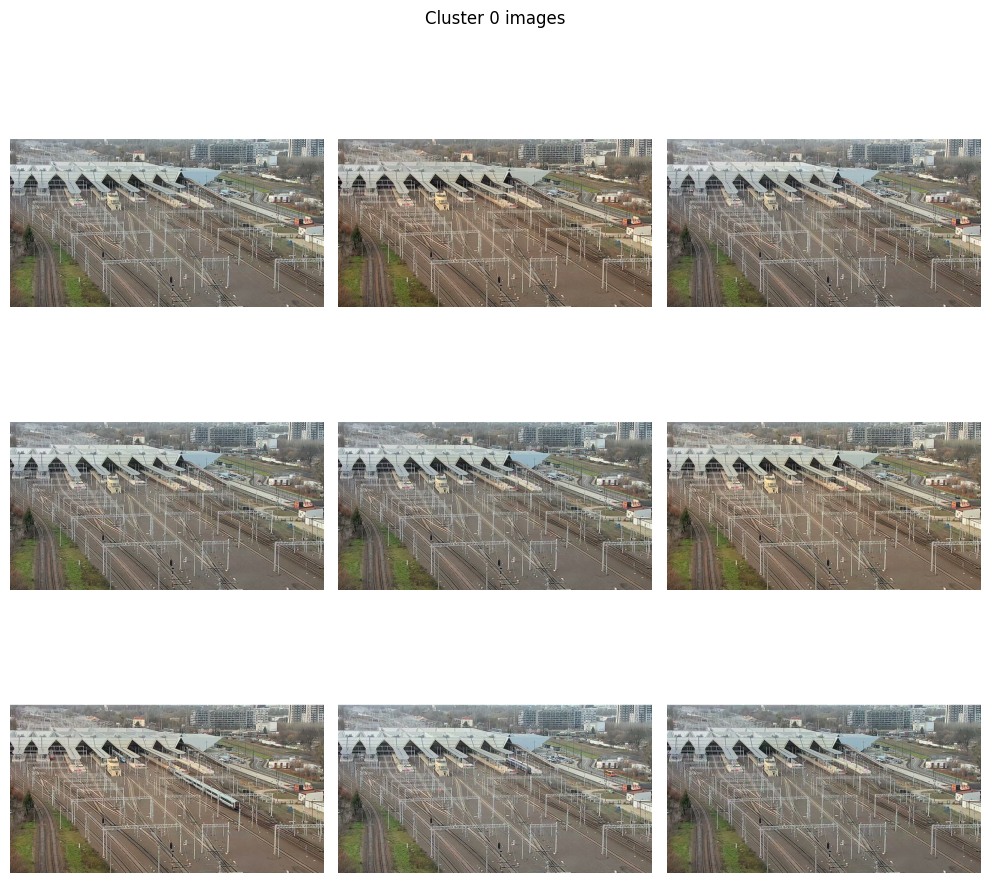

In [159]:
cluster_zero_images = []
for i in range(len(test_images)):
    if clusters[i]==0:
        cluster_zero_images.append(test_images[i])


plt.figure(figsize=(10, 10))

for i in range(9): 
    plt.subplot(3, 3, i+1)
    plt.imshow(cluster_zero_images[i])
    
    plt.axis("off")

plt.suptitle('Cluster 0 images')
plt.tight_layout()
plt.show()

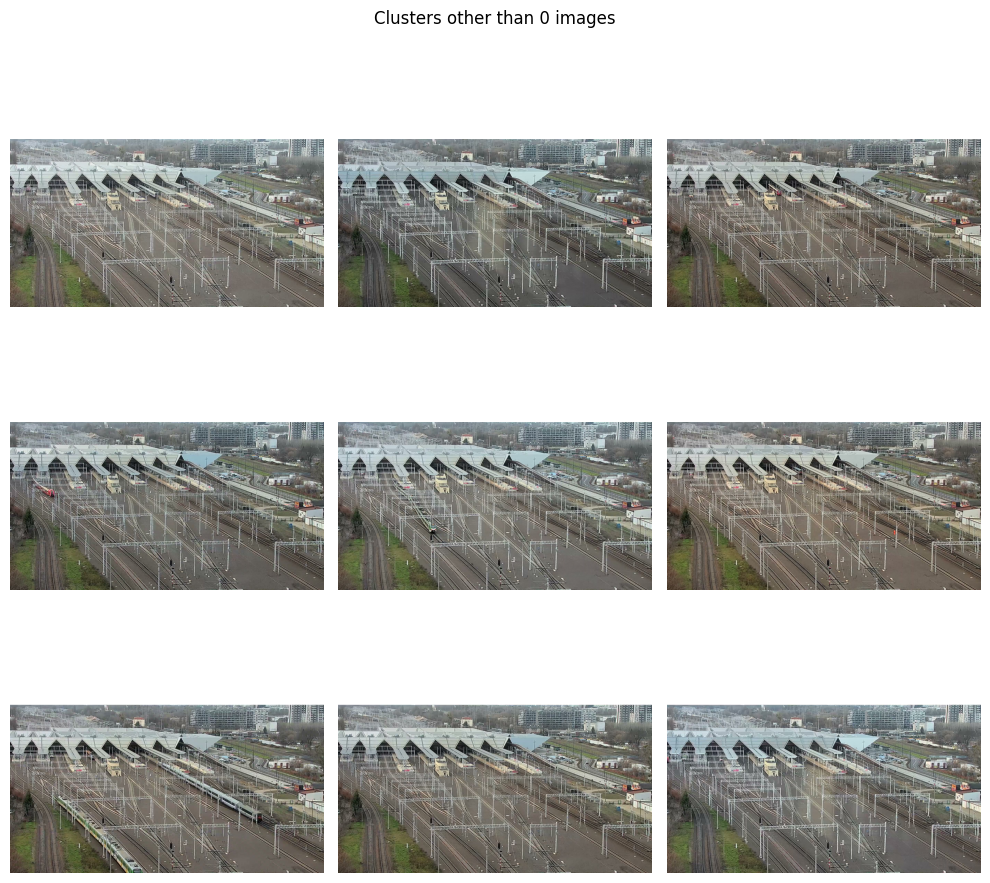

In [160]:
cluster_nonzero_images = []
for i in range(len(test_images)):
    if clusters[i]!=0:
        cluster_nonzero_images.append(test_images[i])


plt.figure(figsize=(10, 10))

for i in range(9): 
    plt.subplot(3, 3, i+1)
    plt.imshow(cluster_nonzero_images[i])
    
    plt.axis("off")

plt.suptitle('Clusters other than 0 images')
plt.tight_layout()
plt.show()